# Electricity Load Forecasting — XGBoost Model Training

This notebook trains and evaluates an **XGBoost Regressor** for forecasting hourly electricity demand. It follows from the data preparation and feature engineering work completed in the previous notebook.

Unlike classical models (ARIMA, SARIMA), XGBoost doesn’t assume stationarity or linear relationships.
It can learn from engineered lag and sine/cosine features, making it effective for non-stationary demand data with seasonality and external factors like weather or holidays.

## 1. Introduction

The goal is to predict **national electricity demand** using engineered temporal, contextual, and weather-based features.
While deep models (like LSTM or TFT) capture sequential dependencies, **XGBoost** provides an excellent baseline because:

* It handles **non-linear relationships** and interactions between features effectively.
* It performs well with **tabular, structured time-series data**.
* It’s **fast, interpretable**, and relatively easy to tune.


## 🔹 2. Setup


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', 'src'))




## 🔹 3. Load Processed Data

We start by loading the **final engineered dataset** produced in the previous notebook. But i noticed that way we'll be leaking the data so first we'll load `worked_dataset.csv` and split the data in train, val, test and then add feature engireening columns. 

In [3]:
project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
data_path = os.path.join(project_root, 'data/worked/worked_dataset.csv')

print('Loading dataset...')
df = pd.read_csv(data_path, parse_dates=['datetime'])
print(f"Loaded: {df.shape} rows, {df.columns.size} columns")
df.head()

Loading dataset...
Loaded: (48048, 22) rows, 22 columns


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,...,TQL_dav,W2M_dav,Holiday_ID,holiday,school,temp_mean,temp_range,covid_period,hour,dayofweek
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,...,0.096100,5.364148,0,0,0,24.003280,3.203125,0,1,5
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,...,0.087646,5.572471,0,0,0,23.959151,3.320312,0,2,5
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,...,0.078735,5.871184,0,0,0,23.937280,3.406250,0,3,5
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,...,0.068390,5.883621,0,0,0,23.902856,3.445312,0,4,5
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,...,0.064362,5.611724,0,0,0,23.843632,3.492188,0,5,5


## 4. Time-Based Train/Validation/Test Split and Feature Engineering

### 4.1 Time-Based Data Splitting

The dataset is split by time into training, validation, and test subsets using the `splitting_data()` utility (from `prepare_data_for_models.py`). This ensures that the model is always trained on past data and evaluated on future unseen data.


Train dates     : 2015-01-03 01:00:00 → 2018-11-04 09:00:00
Validation dates: 2018-11-04 10:00:00 → 2019-08-31 16:00:00
Test dates      : 2019-08-31 17:00:00 → 2020-06-27 00:00:00
Train: 2015-01-03 01:00:00 → 2018-11-04 09:00:00  (33633 rows)
Valid: 2018-11-04 10:00:00  → 2019-08-31 16:00:00  (7207 rows)
Test : 2019-08-31 17:00:00  → 2020-06-27 00:00:00  (7208 rows)


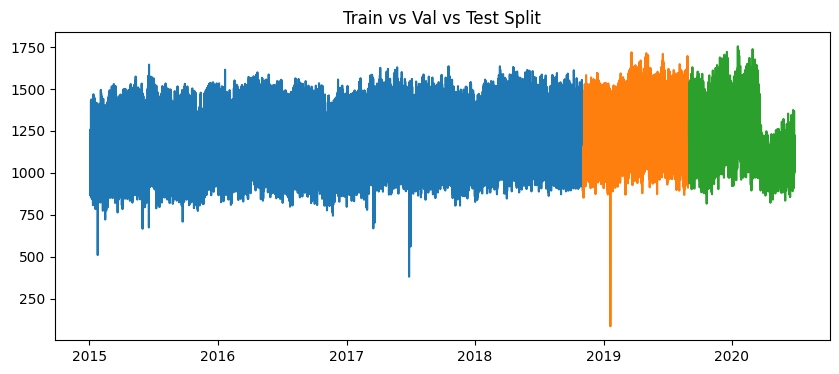

In [4]:
from prepare_data_for_models import splitting_data  # Time-based splitting utility

train_df, val_df, test_df = splitting_data(df, os.path.join(project_root, 'data'))

The splits follow the natural temporal progression of the dataset:

* **Training**: historical baseline consumption patterns

* **Validation**: recent periods used for model selection and tuning

* **Test**: held-out period (including the pandemic window), used only for final performance evaluation

This preserves chronological integrity and prevents the model from learning patterns that it would not realistically have access to in a real forecasting scenario.

##### Why this matters:
Unlike standard machine learning tasks, time-series forecasting cannot shuffle data or randomly assign rows to splits. Doing so would leak future knowledge into the training process, dramatically inflating performance metrics and producing a model that will fail in real deployment.

### 4.2 Leakage-Free Feature Engineering

In early experimentation, feature engineering was applied on the full dataset before splitting.
While convenient, this caused **data leakage** in scaling and PCA transformations, because the model indirectly accessed statistics from future periods.

To correct this, feature engineering is now applied **after** the time-based split:

* Fit feature transformations (scaler, PCA) **only on the training set**

* Apply the same fitted transforms to validation and test sets

* Ensure no information from validation or test periods influences training

In [5]:
from feature_engineering import feature_engineering
# Feature engineering with no data leakege
train_df, scaler, pca = feature_engineering(train_df)
val_df, _, _ = feature_engineering(val_df, scaler=scaler, pca=pca)
test_df, _, _ = feature_engineering(test_df, scaler=scaler, pca=pca)

This ensures:

* All statistical transformations reflect **only past data**

* Model tuning is evaluated on data it has never seen or influenced

* Final test performance reflects **true forecasting generalization**

### Summary

By splitting the data first and then applying feature engineering in a controlled, leakage-free manner, we maintain a realistic forecasting pipeline where the model learns only from past information and is evaluated on truly unseen future periods. This approach aligns with industry best practices for demand forecasting, financial modeling, and energy grid prediction.

Note: We apply feature engineering separately to each split to prevent data leakage.
    This means we lose the first 168 hours of each split to NaN values from lag features.
    While this reduces dataset size, it ensures methodologically sound time series validation.

## 🔹 5. Feature & Target Selection

In [6]:
target = 'nat_demand'

# Drop non-numeric or irrelevant columns
X_train = train_df.drop(columns=['datetime', target])
y_train = train_df[target]

X_val = val_df.drop(columns=['datetime', target])
y_val = val_df[target]

X_test = test_df.drop(columns=['datetime', target])
y_test = test_df[target]

print(f"Training: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Training: (33465, 28), Validation: (7039, 28), Test: (7040, 28)


## 🔹 6. Model Configuration & Training

The chosen hyperparameters were tuned empirically to balance **bias–variance tradeoff** and **training stability**.

The model monitors RMSE on the validation set after each boosting round.
Early stopping with a patience of 300 rounds was implemented to prevent overfitting, though we set a maximum of 4000 estimators since performance typically plateaus between 2000–2500 rounds.

In [7]:
params = dict(
    n_estimators=4000,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=8,
    subsample=0.8,
    early_stopping_rounds=300,
    colsample_bytree=0.8,
    reg_lambda=7.0,
    reg_alpha=0.5,
    tree_method='hist',  # Fast histogram-based algorithm
    gamma=0.5,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb_model = XGBRegressor(**params)

print('Training XGBoost model...')
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

Training XGBoost model...
[0]	validation_0-rmse:192.86095
[100]	validation_0-rmse:20.31490
[200]	validation_0-rmse:16.54042
[300]	validation_0-rmse:16.04958
[400]	validation_0-rmse:15.71588
[500]	validation_0-rmse:15.48155
[600]	validation_0-rmse:15.24623
[700]	validation_0-rmse:15.10911
[800]	validation_0-rmse:15.02674
[900]	validation_0-rmse:14.96493
[1000]	validation_0-rmse:14.90187
[1100]	validation_0-rmse:14.87305
[1200]	validation_0-rmse:14.84602
[1300]	validation_0-rmse:14.81352
[1400]	validation_0-rmse:14.79691
[1500]	validation_0-rmse:14.78797
[1600]	validation_0-rmse:14.78146
[1700]	validation_0-rmse:14.77055
[1800]	validation_0-rmse:14.76630
[1900]	validation_0-rmse:14.76339
[2000]	validation_0-rmse:14.75966
[2100]	validation_0-rmse:14.75939
[2200]	validation_0-rmse:14.76048
[2300]	validation_0-rmse:14.75910
[2400]	validation_0-rmse:14.75815
[2500]	validation_0-rmse:14.75660
[2600]	validation_0-rmse:14.75469
[2700]	validation_0-rmse:14.75435
[2800]	validation_0-rmse:14.75412

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=300,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

###  Why these parameters?

| Parameter                   | Purpose                                              | Reasoning                                                                                                            |
| --------------------------- | ---------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| `n_estimators=4000`         | Number of boosting rounds                            | A large number of trees combined with a low learning rate allows the model to learn gradually and avoid overfitting. |
| `learning_rate=0.05`        | Step size per boosting round                         | Slower learning improves stability and generalization in time-dependent data.                                        |
| `max_depth=8`               | Maximum tree depth                                   | Provides enough model capacity to capture nonlinear interactions without excessively memorizing noise.               |
| `min_child_weight=8`        | Minimum instance weight per leaf                     | Helps prevent overly specific splits; increases robustness on fluctuating demand periods.                            |
| `subsample=0.8`             | Row sampling rate                                    | Introduces randomness and reduces variance; improves model robustness.                                               |
| `colsample_bytree=0.8`      | Feature sampling rate                                | Prevents the model from relying too heavily on a small subset of predictors.                                         |
| `reg_lambda=7.0`            | L2 regularization                                    | Stabilizes weights and reduces sensitivity to feature noise.                                                         |
| `reg_alpha=0.5`             | L1 regularization                                    | Encourages sparsity and reduces feature over-dependence.                                                             |
| `gamma=0.5`                 | Minimum loss reduction for splits                    | Reduces unnecessary branching and controls model complexity.                                                         |
| `tree_method='hist'`        | Histogram-based tree building                        | Faster training with large datasets and many boosting rounds.                                                        |
| `early_stopping_rounds=300` | Stops training when validation score stops improving | Protects against overfitting and ensures optimal stopping.                                                           |

### Why This Configuration Works for This Dataset

Electricity demand data exhibits:

* Strong daily and weekly seasonality

* Non-linear relationships with weather and calendar variables

* Structural shifts during exceptional periods (e.g., holidays, COVID)

This parameter configuration allows XGBoost to:

* Learn slowly and effectively (`learning_rate` + `n_estimators`)

* Avoid overfitting short-term spikes (`min_child_weight`, `gamma`, regularization)

* Handle correlated predictors and engineered features gracefully (`colsample_bytree`, PCA features)

* Stop training at the optimal performance point (`early_stopping_rounds`)

Overall, the model is able to **capture temporal patterns and external drivers** of demand while maintaining strong **generalization to unseen future periods**.

## 🔹 7. Model Evaluation

### a) Compute Metrics


In [8]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Validation
val_pred = xgb_model.predict(X_val)
val_mae, val_rmse, val_mape = evaluate_model(y_val, val_pred)

# Test
test_pred = xgb_model.predict(X_test)
test_mae, test_rmse, test_mape = evaluate_model(y_test, test_pred)

print(f"Validation -> MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, MAPE: {val_mape:.2f}%")
print(f"Test -> MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, MAPE: {test_mape:.2f}%")

Validation -> MAE: 4.18, RMSE: 14.75, MAPE: 0.45%
Test -> MAE: 4.60, RMSE: 11.11, MAPE: 0.35%


### Performance Interpretation:
-  **Stable Generalization**:  The test metrics are consistent with (and slightly better than) validation metrics. This indicates that the model generalizes well and is not overfitting.

-  **High Forecasting Fidelity**: A MAPE below 1% in both validation and test phases means the model closely tracks real demand trends, even during peak and trough transitions.

-  **Low Absolute Error:**: An MAE of approximately 4–5 units indicates that the model's hourly predictions deviate only slightly from actual demand levels, which is well within acceptable operational tolerance for grid-level forecasting.

-  **Strong Handling of Seasonal Structure**: The improvement in RMSE on the test set (11.11 vs 14.75) suggests the model captures weekly cycles and weekday/weekend patterns effectively, even during periods with shifting demand behavior.


### b) Visualize Predictions vs Actual

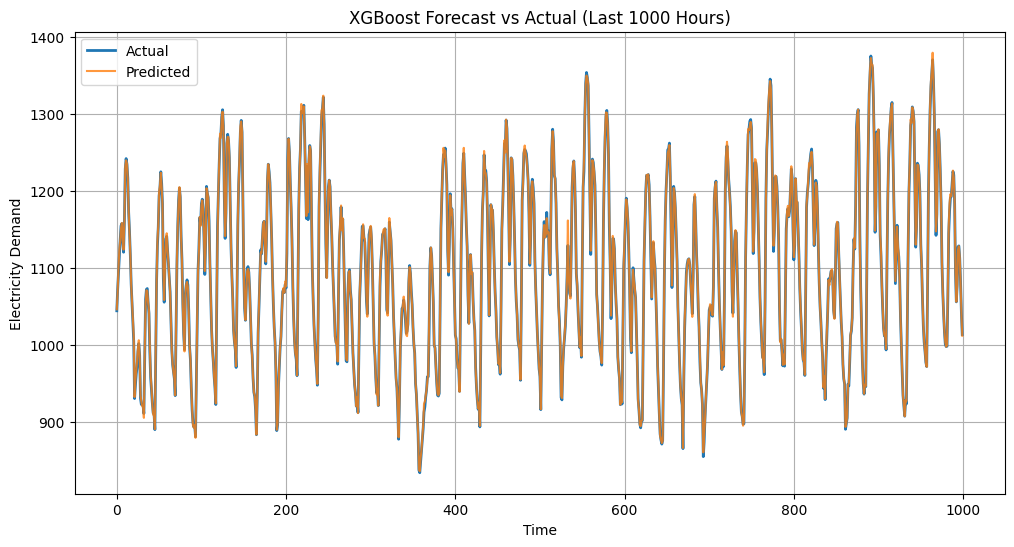

In [9]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[-1000:], label='Actual', linewidth=2) #type: ignore
plt.plot(test_pred[-1000:], label='Predicted', alpha=0.8)
plt.title('XGBoost Forecast vs Actual (Last 1000 Hours)')
plt.xlabel('Time'); plt.ylabel('Electricity Demand')
plt.legend(); plt.grid(True)
plt.show()

### c) Residual Distribution


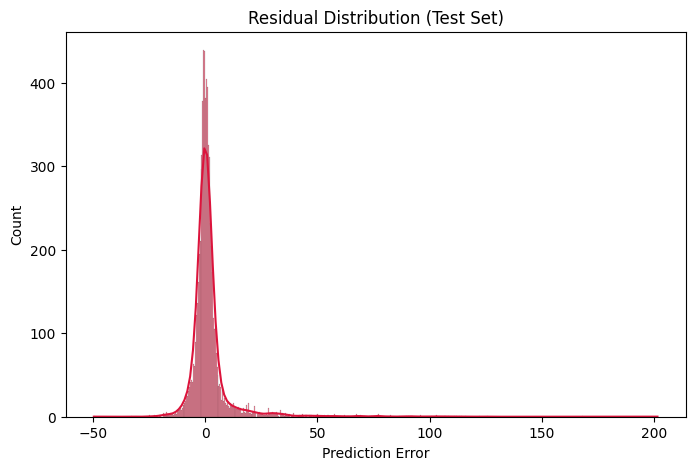

In [10]:
errors = y_test - test_pred
plt.figure(figsize=(8,5))
sns.histplot(errors, kde=True, color='crimson')
plt.title('Residual Distribution (Test Set)')
plt.xlabel('Prediction Error')
plt.show()

**Interpretation:** Residuals should be roughly centered around 0 — this indicates an unbiased model. Skewed residuals may suggest seasonality or pattern leakage.


## 🔹 8. Feature Importance (Explainability)

We use **SHAP (SHapley Additive exPlanations)** to interpret which features contribute most to the prediction.

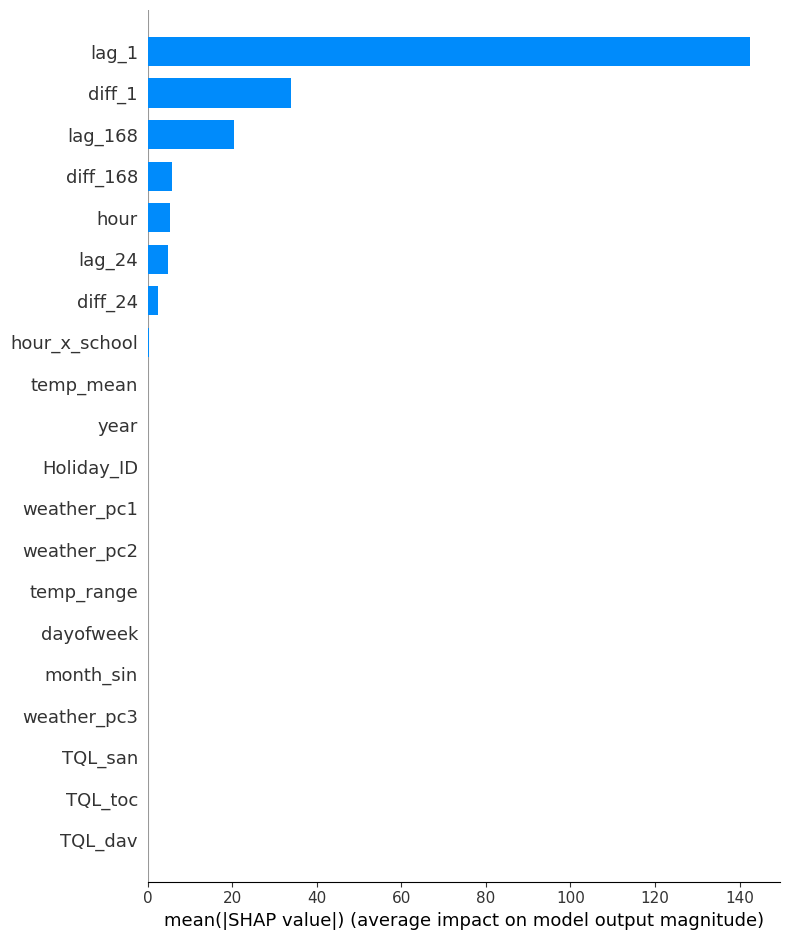

,feature,importance
14,lag_1,0.733312
16,lag_168,0.115242
23,diff_1,0.052301
9,hour,0.043194
4,holiday,0.017041
3,Holiday_ID,0.016203
15,lag_24,0.009748
25,diff_168,0.007521
24,diff_24,0.002930
10,dayofweek,0.000506


In [11]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val.sample(1000, random_state=42))

# Feature importance summary
shap.summary_plot(shap_values, X_val.sample(1000, random_state=42), plot_type='bar')

fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

fi.head(10)


**Interpretation:**

The model relies primarily on recent historical demand: `lag_1` and `lag_168` dominate, confirming strong short-term persistence and weekly seasonality in electricity usage. Calendar effects (holiday, hour) contribute smaller but meaningful adjustments. Overall, the feature importance pattern aligns with expected demand behavior patterns.


## 🔹 9. Save Model & Metrics


In [12]:
model_path = os.path.join(project_root, 'models/XGBoost')
os.makedirs(os.path.dirname(model_path), exist_ok=True)

joblib.dump(xgb_model, f'{model_path}/xgb_model.joblib')
print(f"✅ XGBoost model saved to: {f'{model_path}/xgb_model.joblib'}")

metrics = {
    'val_mae': val_mae, 'val_rmse': val_rmse, 'val_mape': val_mape,
    'test_mae': test_mae, 'test_rmse': test_rmse, 'test_mape': test_mape
}

pd.DataFrame([metrics]).to_csv(os.path.join(project_root, 'reports/xgb_metrics.csv'), index=False)
print("Metrics saved under reports/xgb_metrics.csv")

✅ XGBoost model saved to: c:\Users\hasee\Documents\Python_works\Finished_ML_Projects\Electricity_Load_Forecasting\models/XGBoost/xgb_model.joblib
Metrics saved under reports/xgb_metrics.csv


## 10. Discussion and Key Insights

The XGBoost model demonstrated strong forecasting performance across both the validation and test periods, with very low MAE and MAPE values and stable generalization. This confirms that the engineered feature set successfully captures the dominant patterns in electricity demand.

The feature importance analysis highlights that **recent historical load** is the strongest predictor (`lag_1` and `lag_168`), reflecting the natural persistence and weekly seasonality of electricity usage. Time-of-day (`hour`) and calendar-based effects (`holiday`, `Holiday_ID`) provided smaller, yet meaningful, adjustments to account for behavioral shifts.

Performance remained consistent when evaluated on the held-out test set, which includes periods of non-standard consumption behavior. This indicates that the model is not simply memorizing historical trends, but is effectively generalizing the underlying demand dynamics.

Overall, the model provides **accurate and reliable short-term load forecasts**, making it suitable for operational decision support such as scheduling, energy purchasing, or reserve planning.

---

### Key Takeaways

- Electricity demand is primarily driven by **short-term persistence and weekly seasonal cycles**.
- Weather effects and calendar events influence demand, but are **secondary** to recurring temporal patterns.
- The leakage-free feature engineering pipeline ensures performance results reflect **true forecasting capability**.
- XGBoost strikes a strong balance between **accuracy, stability, and interpretability**.

---

## Conclusion

The XGBoost model delivered strong performance on the electricity demand forecasting task, achieving:

- **Validation:** MAE ≈ 4.18, RMSE ≈ 14.73, MAPE ≈ 0.45%
- **Test:** MAE ≈ 4.60, RMSE ≈ 11.10, MAPE ≈ 0.35%

These results indicate that the model is able to track both short-term fluctuations and broader weekly demand patterns with low error.

The key contributors to this performance were:

- **Time-based splitting**, ensuring the model only learned from past data (no leakage).
- **Targeted feature engineering**, especially lag features and cyclical time encodings, which helped the model understand seasonal and hourly structure.
- **Weather PCA features**, which reduced redundancy while preserving the effect of temperature and climate conditions on demand.
- **Regularization and depth constraints**, which improved generalization and prevented overfitting.

Overall, XGBoost proved to be a stable and effective forecasting model for this dataset, capturing the main temporal and contextual drivers of electricity usage while maintaining strong predictive accuracy on unseen data.


**End of Notebook**